# NREL WIND Toolkit - NSRDB Comparison

This notebook compares the National Renewable Energy Laboratory (NREL) Wind Integration National Dataset (WIND) Toolkit and National Solar Radiation Database (NSRDB) data. The data is provided from Amazon Web Services using the HDF Group's Highly Scalable Data Service (HSDS).

Please consult the README file for setup instructions prior to running this notebook.


In [1]:
from collections import OrderedDict
import h5pyd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wilcoxon, ttest_rel
from scipy.spatial import cKDTree
from pyproj import Proj

#custom plotting properties
sns.set_style("white")
sns.set_style("ticks")
meanprops = dict(marker='o', markeredgecolor='black', markerfacecolor="None",
                 markersize=5)


def WTK_idx(wtk, lat_lon):
    """
    Function to find the nearest x/y WTK indices for a given lat/lon using Proj4 projection library
    
    Parameters
    ----------
    wtk : 'h5pyd.File'
        h5pyd File instance for the WTK
    lat_lon : tuple | list
        (lat, lon) coordinates of interest
        
    Results
    -------
    ij : 'tuple'
        x/y coordinate in the database of the closest pixel to coordinate of interest
    """
    dset_coords = wtk['coordinates']
    projstring = """+proj=lcc +lat_1=30 +lat_2=60 
                    +lat_0=38.47240422490422 +lon_0=-96.0 
                    +x_0=0 +y_0=0 +ellps=sphere 
                    +units=m +no_defs """
    projectLcc = Proj(projstring)
    origin_ll = reversed(dset_coords[0][0])  # Grab origin directly from database
    origin = projectLcc(*origin_ll)
    
    lon_lat = reversed(lat_lon)
    coords = projectLcc(*lon_lat)
    delta = np.subtract(coords, origin)
    ij = [int(round(x / 2000)) for x in delta]
    return tuple(reversed(ij))


def NSRDB_idx(nsrdb, lat_lon):
    """
    Function to find the NSRDB site index for a given lat/lon using a KDTree
    
    Parameters
    ----------
    nsrdb : 'h5pyd.File'
        h5pyd File instance for the NSRDB
    lat_lon : tuple | list
        (lat, lon) coordinates of interest
        
    Results
    -------
    ij : 'tuple'
        x/y coordinate in the database of the closest pixel to coordinate of interest
    """
    # Prefer an explicit 'coordinates' dataset; fall back to coordinates stored in 'meta'
    try:
        dset_coords = nsrdb['coordinates'][...]
    except Exception:
        meta = pd.DataFrame(nsrdb['meta'][...])
        # ensure we have an (N,2) numpy array of lat/lon
        dset_coords = meta[['latitude', 'longitude']].values
    tree = cKDTree(dset_coords)
    dist, pos = tree.query(np.array(lat_lon))
    return pos


# Compare NSRDB to WIND Toolkit

In [2]:
# Specify a latitude and longitude
lat_lon = (32.785450, -96.800734) # Dallas, TX

## NSRDB Site

In [3]:
# Find nearest NSRDB site to desired lat_lon
with h5pyd.File('/nrel/nsrdb/GOES/aggregated/v4.0.0/nsrdb_2017.h5') as nsrdb:
    idx = NSRDB_idx(nsrdb, lat_lon)
    site_meta = pd.DataFrame(nsrdb['meta'][[idx]])
    try:
        nsrdb_lat_lon = nsrdb['coordinates'][idx]
    except Exception:
        # fall back to reading lat/lon from meta
        nsrdb_lat_lon = site_meta[['latitude','longitude']].values[0]
    print('NSRDB nearest site coordinates = ', nsrdb_lat_lon)
    display(site_meta)


NSRDB nearest site coordinates =  [ 32.77 -96.82]


,latitude,longitude,elevation,timezone,country,state,county
0,32.77,-96.82,133,-6,b'United States',b'Texas',b'Dallas'


In [4]:
# Extract hourly irradiance, temperature, wind speed, and solar zenith angle from 2007-2013 NSRDB files
nsrdb_data = []
for year in range(2007, 2014):
    file = '/nrel/nsrdb/GOES/aggregated/v4.0.0/nsrdb_{}.h5'.format(year)
    df = pd.DataFrame()
    with h5pyd.File(file, 'r') as nsrdb:
        for dset in ['ghi', 'dni', 'dhi', 'wind_speed', 'air_temperature', 'solar_zenith_angle']:
            ds = nsrdb[dset]
            df[dset] = ds[::2, idx] / ds.attrs['psm_scale_factor']
        
        df.index = pd.to_datetime(nsrdb['time_index'][::2].astype(str))
        df.index.name = 'datetime'
    
    nsrdb_data.append(df)
    
nsrdb_data = pd.concat(nsrdb_data)
nsrdb_data.head()

,ghi,dni,dhi,wind_speed,air_temperature,solar_zenith_angle
datetime,,,,,,
2007-01-01 00:00:00+00:00,0.0,0.0,0.0,1.9,4.3,96.28
2007-01-01 01:00:00+00:00,0.0,0.0,0.0,1.7,3.4,108.14
2007-01-01 02:00:00+00:00,0.0,0.0,0.0,1.8,2.8,120.42
2007-01-01 03:00:00+00:00,0.0,0.0,0.0,2.0,2.3,132.96
2007-01-01 04:00:00+00:00,0.0,0.0,0.0,2.4,2.1,145.55


## WIND Toolkit Site

In [5]:
# Find nearest WTK site to desired lat_lon
with h5pyd.File("/nrel/wtk-us.h5", 'r') as wtk:
    wtk_ij = WTK_idx(wtk, lat_lon)
    wtk_lat_lon = wtk['coordinates'][wtk_ij[0], wtk_ij[1]]
    print('WTK nearest site coordinates = ', wtk_lat_lon)

WTK nearest site coordinates =  (32.789417, -96.789795)


In [6]:
# Extract hourly irradiance, temperature, and wind speed from WTK
with h5pyd.File("/nrel/wtk-us.h5", 'r') as wtk:
    dt = pd.to_datetime(wtk['datetime'][:].astype(str))
    wtk_data = OrderedDict()
    for var in ['DIF', 'DNI', 'GHI', 'temperature_2m', 'windspeed_10m']:
        wtk_data[var] = wtk[var][:, wtk_ij[0], wtk_ij[1]]

    wtk_data = pd.DataFrame(wtk_data, index=dt)
    wtk_data.head()

## Comparison

Combine NSRDB and WTK datasets to allow for comparison

In [7]:
nsrdb_df = nsrdb_data.copy()
nsrdb_df = nsrdb_df.rename(columns={'dhi': 'DHI', 'dni': 'DNI', 'ghi': 'GHI',
                                        'air_temperature': 'Temperature', 'wind_speed': 'Wind Speed'})
nsrdb_df['dataset'] = 'NSRDB'

wtk_df = wtk_data.copy()
wtk_df = wtk_df.rename(columns={'DIF': 'DHI', 'temperature_2m': 'Temperature', 'windspeed_10m': 'Wind Speed'})
wtk_df['dataset'] = 'WTK'
# convert WTK temperature from Kelvin to Celsius
wtk_df['Temperature'] = wtk_df['Temperature'] - 273.15

comp_ds = pd.concat([nsrdb_df, wtk_df])

# Ensure the index is a DatetimeIndex (some earlier steps may not have been run)
# Convert to timezone-aware UTC to avoid mixing tz-aware and tz-naive datetimes
if not isinstance(comp_ds.index, pd.DatetimeIndex):
    try:
        comp_ds.index = pd.to_datetime(comp_ds.index, errors='raise', utc=True)
    except Exception:
        comp_ds.index = pd.to_datetime(comp_ds.index, errors='coerce', utc=True)
        if comp_ds.index.isnull().any():
            raise ValueError('comp_ds.index contains non-datetime values after to_datetime conversion')

# Extract year and month from the UTC-aware index
comp_ds['year'] = comp_ds.index.year
comp_ds['month'] = comp_ds.index.month

# Shift hour to local time using timezone offset from site_meta when available
# site_meta['timezone'] may be bytes or numeric; fall back to 0 if missing or invalid
tz_offset = 0
try:
    tz_val = site_meta['timezone'].iloc[0]
    if isinstance(tz_val, (bytes, bytearray)):
        tz_val = tz_val.decode()
    tz_offset = int(float(tz_val))
except Exception:
    tz_offset = 0

# Add the offset (hours) to the UTC index to compute local hour
try:
    local_index = comp_ds.index + pd.to_timedelta(f"{tz_offset}h")
    comp_ds['hour'] = local_index.hour
except Exception:
    # Last-resort fallback: compute hour from integer unix timestamps
    comp_ds['hour'] = ((comp_ds.index.view('i8') // 10**9 + tz_offset * 3600) % 86400) // 3600

comp_ds.head()

,GHI,DNI,DHI,Wind Speed,Temperature,solar_zenith_angle,dataset,year,month,hour
2007-01-01 00:00:00+00:00,0.0,0.0,0.0,1.9,4.3,96.28,NSRDB,2007,1,18
2007-01-01 01:00:00+00:00,0.0,0.0,0.0,1.7,3.4,108.14,NSRDB,2007,1,19
2007-01-01 02:00:00+00:00,0.0,0.0,0.0,1.8,2.8,120.42,NSRDB,2007,1,20
2007-01-01 03:00:00+00:00,0.0,0.0,0.0,2.0,2.3,132.96,NSRDB,2007,1,21
2007-01-01 04:00:00+00:00,0.0,0.0,0.0,2.4,2.1,145.55,NSRDB,2007,1,22


[Irradiance](#Irradiance-Variables) | [Meteorological](#Meterological-Variables)

# Irradiance Variables
For irradiance variables non-daylight hours need to be removed

In [8]:
# Daylight hours have a zenith angle <= 89 degrees
daylight = nsrdb_df['solar_zenith_angle'] <= 89
daylight = nsrdb_df.loc[daylight].index
cols = ['DNI', 'GHI', 'DHI', 'dataset', 'year', 'month', 'hour']
solar_comp = comp_ds.loc[daylight, cols].copy()
solar_comp.head()

,DNI,GHI,DHI,dataset,year,month,hour
datetime,,,,,,,
2007-01-01 14:00:00+00:00,503.000000,67.000000,25.000000,NSRDB,2007,1,8
2007-01-01 14:00:00+00:00,49.096680,19.203796,15.747559,WTK,2007,1,8
2007-01-01 15:00:00+00:00,806.000000,253.000000,45.000000,NSRDB,2007,1,9
2007-01-01 15:00:00+00:00,484.832306,205.748169,85.741760,WTK,2007,1,9
2007-01-01 16:00:00+00:00,936.000000,430.000000,54.000000,NSRDB,2007,1,10


[GHI](#Global-Horizontal-Irradiance) | [DHI](#Diffuse-Horizontal-Irradiance) | [DNI](#Direct-Normal-Irradiance)

#### Global Horizontal Irradiance

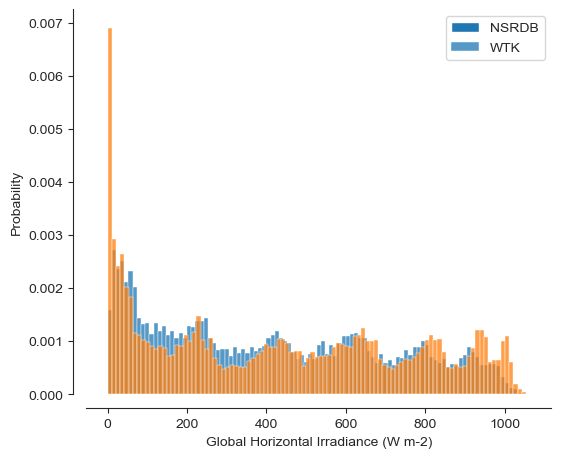

p-value = 0.00


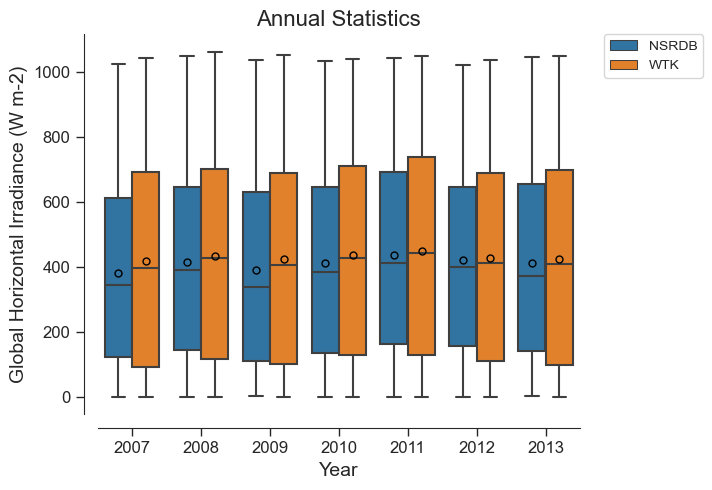

,2007,2008,2009,2010,2011,2012,2013
p-value,0.0,0.0,0.0,0.0,0.0,0.0,0.0


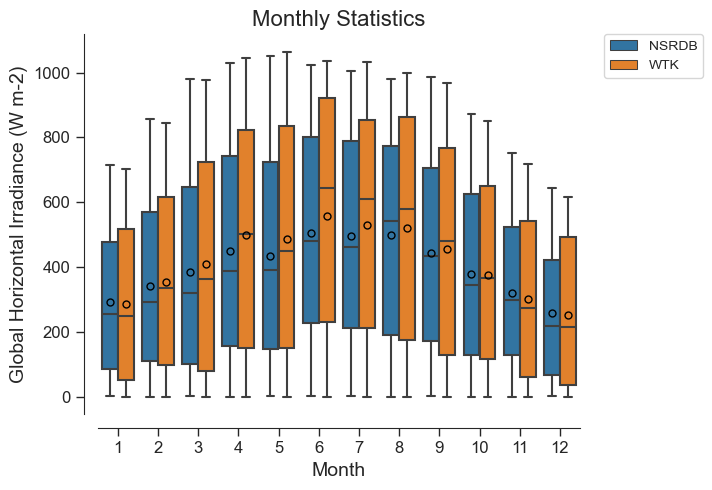

,1,2,3,4,5,6,7,8,9,10,11,12
p-value,0.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


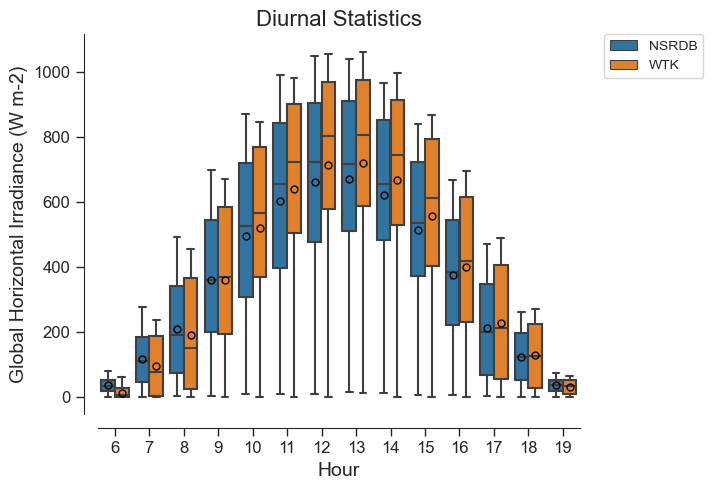

,6,7,8,9,10,11,12,13,14,15,16,17,18,19
p-value,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
variable = 'GHI'
label = 'Global Horizontal Irradiance (W m-2)'

nsrdb = solar_comp.loc[solar_comp['dataset'] == 'NSRDB', variable]
wtk = solar_comp.loc[solar_comp['dataset'] == 'WTK', variable]
fig, ax = plt.subplots(figsize=((6,5)), dpi=100)
sns.histplot(nsrdb, bins=100, ax=ax, stat='density', element='bars')
sns.histplot(wtk, bins=100, ax=ax, stat='density', element='bars')
sns.despine(offset=10, trim=False)
plt.ylabel('Probability')
plt.xlabel(label)
plt.legend(['NSRDB', 'WTK'])
plt.show()

p_val = wilcoxon(nsrdb, wtk)[1]
print('p-value = {:.2f}'.format(p_val))

fig = plt.figure(figsize=(6,5), dpi=100)
axis = fig.add_subplot(111)
axis.set_title('Annual Statistics', fontsize=16)
sns.boxplot(x='year', y=variable, hue='dataset', data=solar_comp,
            showfliers=False, ax=axis, showmeans=True, meanprops=meanprops)
sns.despine(offset=10, trim=False)
axis.set_xlabel('Year', fontsize=14)
axis.set_ylabel(label, fontsize=14)
axis.tick_params(axis='x', labelsize=12, width=1, length=6)
axis.tick_params(axis='y', labelsize=12, width=1, length=6)
fig.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
plt.close()

p_vals = pd.DataFrame()
groups = solar_comp.groupby('year')
for group, df in groups:
    nsrdb = df.loc[df['dataset'] == 'NSRDB', variable].values
    wtk = df.loc[df['dataset'] == 'WTK', variable].values
    p_vals.loc['p-value', group] = wilcoxon(nsrdb, wtk)[1]
    
display(p_vals.round(2))


fig = plt.figure(figsize=(6,5), dpi=100)
axis = fig.add_subplot(111)
axis.set_title('Monthly Statistics', fontsize=16)
sns.boxplot(x='month', y=variable, hue='dataset', data=solar_comp,
            showfliers=False, ax=axis, showmeans=True, meanprops=meanprops)
sns.despine(offset=10, trim=False)
axis.set_xlabel('Month', fontsize=14)
axis.set_ylabel(label, fontsize=14)
axis.tick_params(axis='x', labelsize=12, width=1, length=6)
axis.tick_params(axis='y', labelsize=12, width=1, length=6)
fig.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
plt.close()

p_vals = pd.DataFrame()
groups = solar_comp.groupby('month')
for group, df in groups:
    nsrdb = df.loc[df['dataset'] == 'NSRDB', variable].values
    wtk = df.loc[df['dataset'] == 'WTK', variable].values
    p_vals.loc['p-value', group] = wilcoxon(nsrdb, wtk)[1]
    
display(p_vals.round(2))


fig = plt.figure(figsize=(6,5), dpi=100)
axis = fig.add_subplot(111)
axis.set_title('Diurnal Statistics', fontsize=16)
sns.boxplot(x='hour', y=variable, hue='dataset', data=solar_comp,
           showfliers=False, ax=axis, showmeans=True, meanprops=meanprops)
sns.despine(offset=10, trim=False)
axis.set_xlabel('Hour', fontsize=14)
axis.set_ylabel(label, fontsize=14)
axis.tick_params(axis='x', labelsize=12, width=1, length=6)
axis.tick_params(axis='y', labelsize=12, width=1, length=6)
fig.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
plt.close()

p_vals = pd.DataFrame()
groups = solar_comp.groupby('hour')
for group, df in groups:
    nsrdb = df.loc[df['dataset'] == 'NSRDB', variable].values
    wtk = df.loc[df['dataset'] == 'WTK', variable].values
    p_vals.loc['p-value', group] = wilcoxon(nsrdb, wtk)[1]
    
display(p_vals.round(2))

Take aways:
- The WTK reports great GHI than the NSRDB.
- The variability of GHI is also larger in the WTK than the NSRDB.
- The diurnal pattern of GHI is consistent between the NSRDB and WTK.

#### Diffuse Horizontal Irradiance

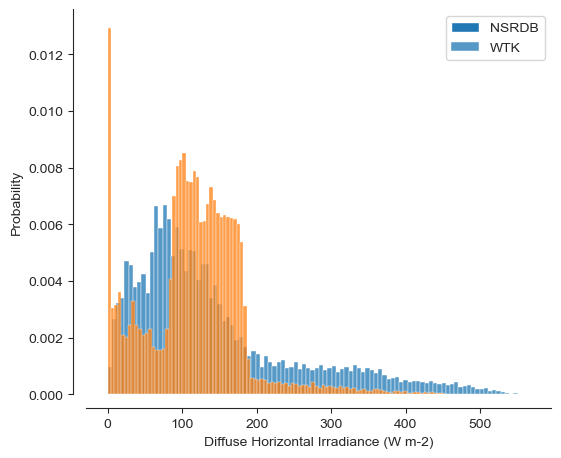

p-value = 0.00


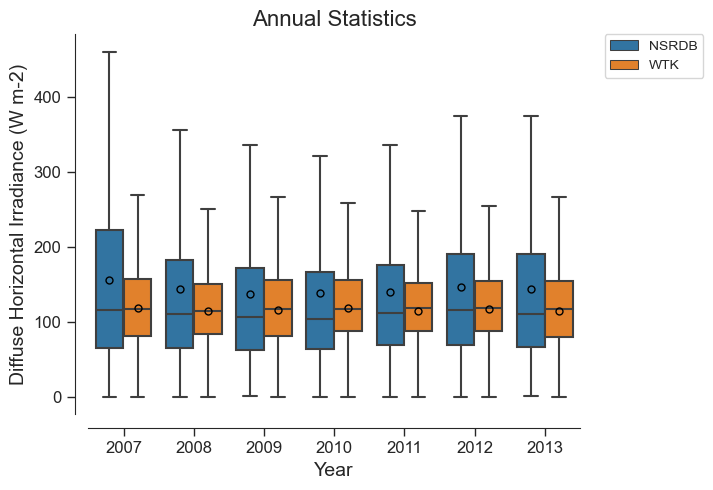

,2007,2008,2009,2010,2011,2012,2013
p-value,0.0,0.0,0.0,0.64,0.0,0.0,0.0


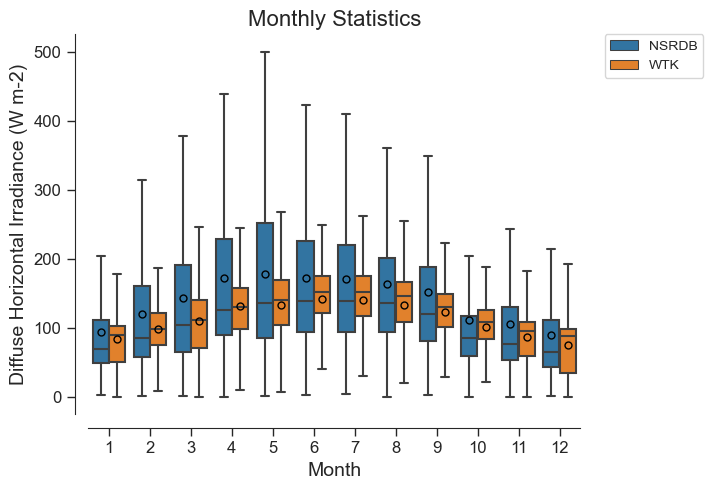

,1,2,3,4,5,6,7,8,9,10,11,12
p-value,0.89,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.03,0.0


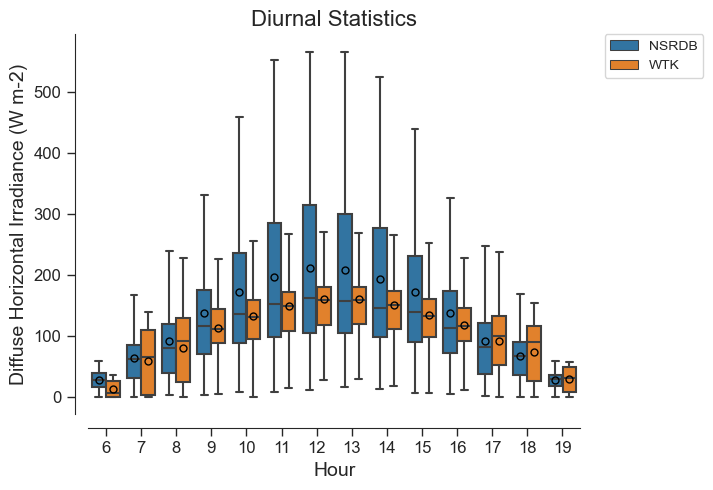

,6,7,8,9,10,11,12,13,14,15,16,17,18,19
p-value,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01


In [10]:
variable = 'DHI'
label = 'Diffuse Horizontal Irradiance (W m-2)'

nsrdb = solar_comp.loc[solar_comp['dataset'] == 'NSRDB', variable]
wtk = solar_comp.loc[solar_comp['dataset'] == 'WTK', variable]
fig, ax = plt.subplots(figsize=((6,5)), dpi=100)
sns.histplot(nsrdb, bins=100, ax=ax, stat='density', element='bars')
sns.histplot(wtk, bins=100, ax=ax, stat='density', element='bars')
sns.despine(offset=10, trim=False)
plt.ylabel('Probability')
plt.xlabel(label)
plt.legend(['NSRDB', 'WTK'])
plt.show()

p_val = wilcoxon(nsrdb, wtk)[1]
print('p-value = {:.2f}'.format(p_val))

fig = plt.figure(figsize=(6,5), dpi=100)
axis = fig.add_subplot(111)
axis.set_title('Annual Statistics', fontsize=16)
sns.boxplot(x='year', y=variable, hue='dataset', data=solar_comp,
            showfliers=False, ax=axis, showmeans=True, meanprops=meanprops)
sns.despine(offset=10, trim=False)
axis.set_xlabel('Year', fontsize=14)
axis.set_ylabel(label, fontsize=14)
axis.tick_params(axis='x', labelsize=12, width=1, length=6)
axis.tick_params(axis='y', labelsize=12, width=1, length=6)
fig.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
plt.close()

p_vals = pd.DataFrame()
groups = solar_comp.groupby('year')
for group, df in groups:
    nsrdb = df.loc[df['dataset'] == 'NSRDB', variable].values
    wtk = df.loc[df['dataset'] == 'WTK', variable].values
    p_vals.loc['p-value', group] = wilcoxon(nsrdb, wtk)[1]
    
display(p_vals.round(2))


fig = plt.figure(figsize=(6,5), dpi=100)
axis = fig.add_subplot(111)
axis.set_title('Monthly Statistics', fontsize=16)
sns.boxplot(x='month', y=variable, hue='dataset', data=solar_comp,
            showfliers=False, ax=axis, showmeans=True, meanprops=meanprops)
sns.despine(offset=10, trim=False)
axis.set_xlabel('Month', fontsize=14)
axis.set_ylabel(label, fontsize=14)
axis.tick_params(axis='x', labelsize=12, width=1, length=6)
axis.tick_params(axis='y', labelsize=12, width=1, length=6)
fig.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
plt.close()

p_vals = pd.DataFrame()
groups = solar_comp.groupby('month')
for group, df in groups:
    nsrdb = df.loc[df['dataset'] == 'NSRDB', variable].values
    wtk = df.loc[df['dataset'] == 'WTK', variable].values
    p_vals.loc['p-value', group] = wilcoxon(nsrdb, wtk)[1]
    
display(p_vals.round(2))


fig = plt.figure(figsize=(6,5), dpi=100)
axis = fig.add_subplot(111)
axis.set_title('Diurnal Statistics', fontsize=16)
sns.boxplot(x='hour', y=variable, hue='dataset', data=solar_comp,
           showfliers=False, ax=axis, showmeans=True, meanprops=meanprops)
sns.despine(offset=10, trim=False)
axis.set_xlabel('Hour', fontsize=14)
axis.set_ylabel(label, fontsize=14)
axis.tick_params(axis='x', labelsize=12, width=1, length=6)
axis.tick_params(axis='y', labelsize=12, width=1, length=6)
fig.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
plt.close()

p_vals = pd.DataFrame()
groups = solar_comp.groupby('hour')
for group, df in groups:
    nsrdb = df.loc[df['dataset'] == 'NSRDB', variable].values
    wtk = df.loc[df['dataset'] == 'WTK', variable].values
    p_vals.loc['p-value', group] = wilcoxon(nsrdb, wtk)[1]
    
display(p_vals.round(2))

Take aways:
- The NSRDB reports greather DHI than the WTK.
- The variability of DHI is also larger in the NSRDB than the WTK.
- The monthly pattern of DHI is not well correlated between the NSRDB and WTK.

#### Direct Normal Irradiance

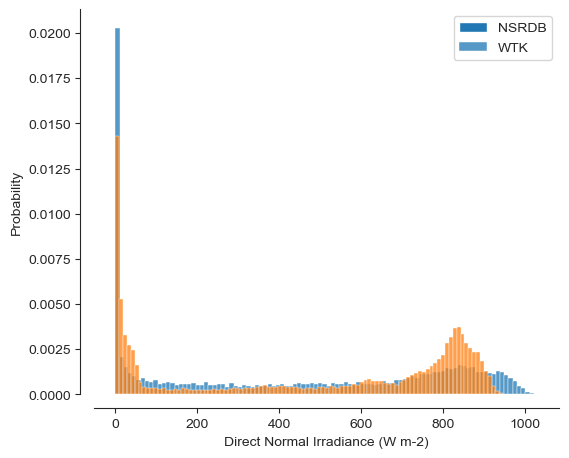

p-value = 0.00


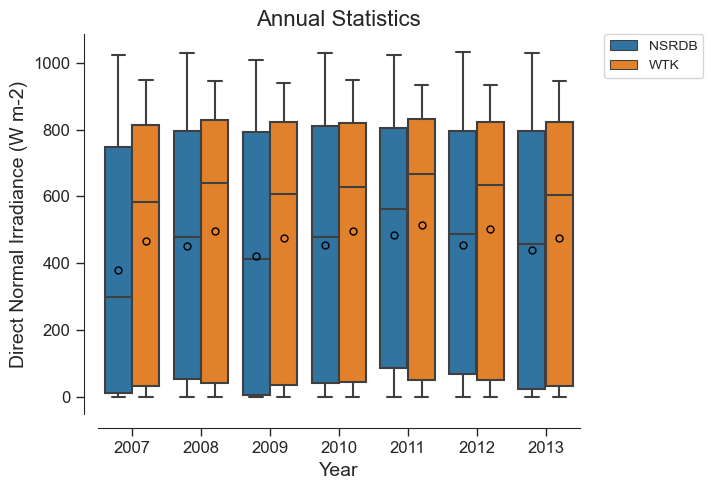

,2007,2008,2009,2010,2011,2012,2013
p-value,0.0,0.44,0.03,0.02,0.02,0.57,0.87


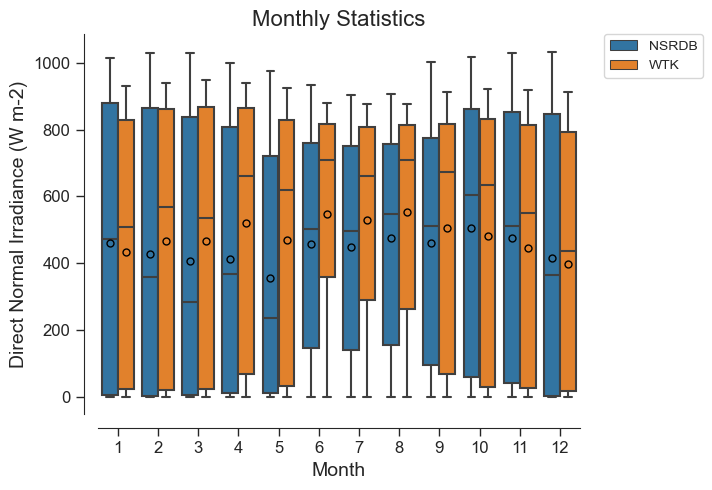

,1,2,3,4,5,6,7,8,9,10,11,12
p-value,0.0,0.0,0.69,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0


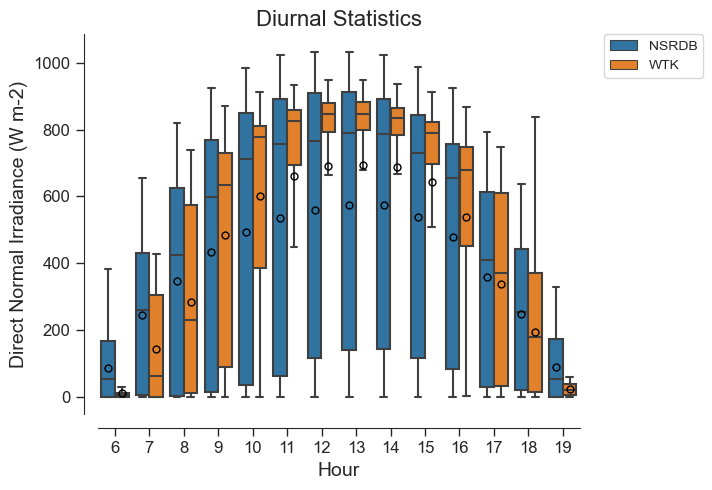

,6,7,8,9,10,11,12,13,14,15,16,17,18,19
p-value,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
variable = 'DNI'
label = 'Direct Normal Irradiance (W m-2)'

nsrdb = solar_comp.loc[solar_comp['dataset'] == 'NSRDB', variable]
wtk = solar_comp.loc[solar_comp['dataset'] == 'WTK', variable]
fig, ax = plt.subplots(figsize=((6,5)), dpi=100)
sns.histplot(nsrdb, bins=100, ax=ax, stat='density', element='bars')
sns.histplot(wtk, bins=100, ax=ax, stat='density', element='bars')
sns.despine(offset=10, trim=False)
plt.ylabel('Probability')
plt.xlabel(label)
plt.legend(['NSRDB', 'WTK'])
plt.show()

p_val = wilcoxon(nsrdb, wtk)[1]
print('p-value = {:.2f}'.format(p_val))

fig = plt.figure(figsize=(6,5), dpi=100)
axis = fig.add_subplot(111)
axis.set_title('Annual Statistics', fontsize=16)
sns.boxplot(x='year', y=variable, hue='dataset', data=solar_comp,
            showfliers=False, ax=axis, showmeans=True, meanprops=meanprops)
sns.despine(offset=10, trim=False)
axis.set_xlabel('Year', fontsize=14)
axis.set_ylabel(label, fontsize=14)
axis.tick_params(axis='x', labelsize=12, width=1, length=6)
axis.tick_params(axis='y', labelsize=12, width=1, length=6)
fig.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
plt.close()

p_vals = pd.DataFrame()
groups = solar_comp.groupby('year')
for group, df in groups:
    nsrdb = df.loc[df['dataset'] == 'NSRDB', variable].values
    wtk = df.loc[df['dataset'] == 'WTK', variable].values
    p_vals.loc['p-value', group] = wilcoxon(nsrdb, wtk)[1]
    
display(p_vals.round(2))


fig = plt.figure(figsize=(6,5), dpi=100)
axis = fig.add_subplot(111)
axis.set_title('Monthly Statistics', fontsize=16)
sns.boxplot(x='month', y=variable, hue='dataset', data=solar_comp,
            showfliers=False, ax=axis, showmeans=True, meanprops=meanprops)
sns.despine(offset=10, trim=False)
axis.set_xlabel('Month', fontsize=14)
axis.set_ylabel(label, fontsize=14)
axis.tick_params(axis='x', labelsize=12, width=1, length=6)
axis.tick_params(axis='y', labelsize=12, width=1, length=6)
fig.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
plt.close()

p_vals = pd.DataFrame()
groups = solar_comp.groupby('month')
for group, df in groups:
    nsrdb = df.loc[df['dataset'] == 'NSRDB', variable].values
    wtk = df.loc[df['dataset'] == 'WTK', variable].values
    p_vals.loc['p-value', group] = wilcoxon(nsrdb, wtk)[1]
    
display(p_vals.round(2))


fig = plt.figure(figsize=(6,5), dpi=100)
axis = fig.add_subplot(111)
axis.set_title('Diurnal Statistics', fontsize=16)
sns.boxplot(x='hour', y=variable, hue='dataset', data=solar_comp,
           showfliers=False, ax=axis, showmeans=True, meanprops=meanprops)
sns.despine(offset=10, trim=False)
axis.set_xlabel('Hour', fontsize=14)
axis.set_ylabel(label, fontsize=14)
axis.tick_params(axis='x', labelsize=12, width=1, length=6)
axis.tick_params(axis='y', labelsize=12, width=1, length=6)
fig.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
plt.close()

p_vals = pd.DataFrame()
groups = solar_comp.groupby('hour')
for group, df in groups:
    nsrdb = df.loc[df['dataset'] == 'NSRDB', variable].values
    wtk = df.loc[df['dataset'] == 'WTK', variable].values
    p_vals.loc['p-value', group] = wilcoxon(nsrdb, wtk)[1]
    
display(p_vals.round(2))

Take aways:
- The average DNI is slightly higher in the WTK on an annual basis.
- The median DNI is substantially higher in the WTK on an annual and monthly basis.
- The variability of DNI is comparable between the NSRDB and WTK on an annuaul and monthly basis. 
- The montly pattern of DNI does not match up well between NSRDB and WTK.
- Of significant note is the fact that DNI varies little in the WTK during the middle of the day,  
  when the variability is greatest in the NSRDB.

### Conclusions for Irradiance Variables

The discrepencies in irradiance values between NSRDB and WTK can be attributed to poor modeling of  
clouds in the underlying WRF model used to derive the WTK.
- WRF appears to underpredict the total cloud over.
    - A known issue with WRF is the ability to represent thin clouds.
- This is consistent with the higher GHI (and DNI), but lower DHI values
- This also explains the lack of mid-day variability in DHI in the WTK data

# Meterological Variables

[Temperature](#Surface-Temperature) | [Wind Speed](#Surface-Wind-Speed)

#### Surface Temperature

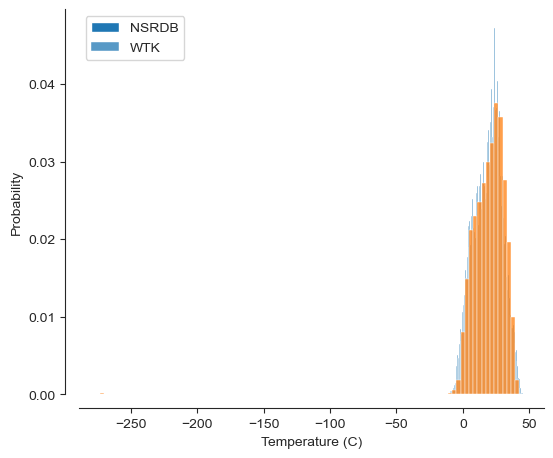

p-value = 0.00


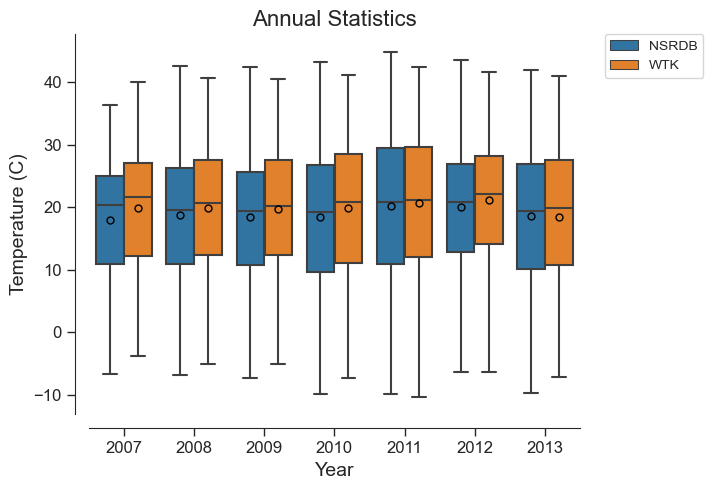

,2007,2008,2009,2010,2011,2012,2013
p-value,0.0,0.0,0.0,0.0,0.0,0.0,0.0


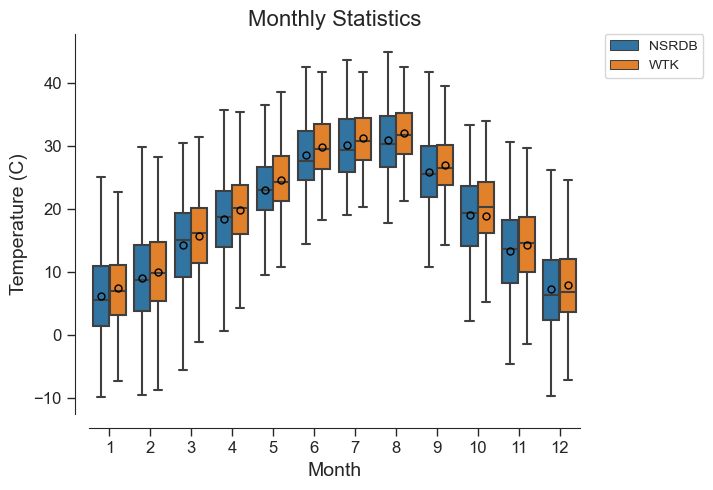

,1,2,3,4,5,6,7,8,9,10,11,12
p-value,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


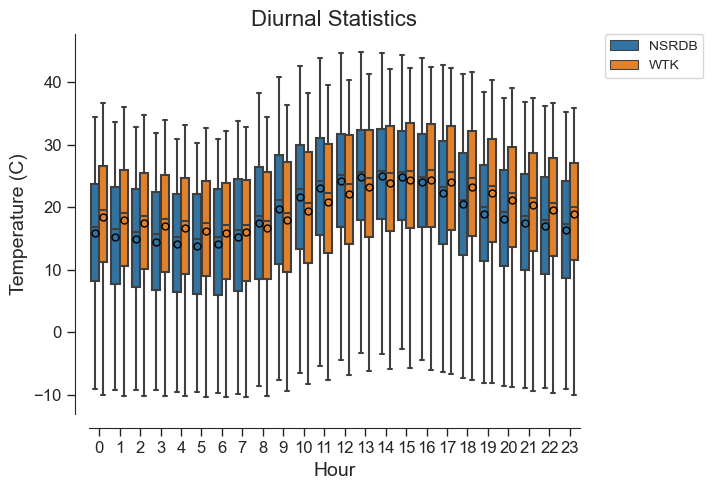

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
p-value,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
variable = 'Temperature'
label = 'Temperature (C)'

nsrdb = comp_ds.loc[comp_ds['dataset'] == 'NSRDB', variable]
wtk = comp_ds.loc[comp_ds['dataset'] == 'WTK', variable]
fig, ax = plt.subplots(figsize=((6,5)), dpi=100)
sns.histplot(nsrdb, bins=100, ax=ax, stat='density', element='bars')
sns.histplot(wtk, bins=100, ax=ax, stat='density', element='bars')
sns.despine(offset=10, trim=False)
plt.ylabel('Probability')
plt.xlabel(label)
plt.legend(['NSRDB', 'WTK'])
plt.show()

p_val = wilcoxon(nsrdb, wtk)[1]
print('p-value = {:.2f}'.format(p_val))

fig = plt.figure(figsize=(6,5), dpi=100)
axis = fig.add_subplot(111)
axis.set_title('Annual Statistics', fontsize=16)
sns.boxplot(x='year', y=variable, hue='dataset', data=comp_ds,
            showfliers=False, ax=axis, showmeans=True, meanprops=meanprops)
sns.despine(offset=10, trim=False)
axis.set_xlabel('Year', fontsize=14)
axis.set_ylabel(label, fontsize=14)
axis.tick_params(axis='x', labelsize=12, width=1, length=6)
axis.tick_params(axis='y', labelsize=12, width=1, length=6)
fig.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
plt.close()

p_vals = pd.DataFrame()
groups = comp_ds.groupby('year')
for group, df in groups:
    nsrdb = df.loc[df['dataset'] == 'NSRDB', variable].values
    wtk = df.loc[df['dataset'] == 'WTK', variable].values
    p_vals.loc['p-value', group] = wilcoxon(nsrdb, wtk)[1]
    
display(p_vals.round(2))


fig = plt.figure(figsize=(6,5), dpi=100)
axis = fig.add_subplot(111)
axis.set_title('Monthly Statistics', fontsize=16)
sns.boxplot(x='month', y=variable, hue='dataset', data=comp_ds,
            showfliers=False, ax=axis, showmeans=True, meanprops=meanprops)
sns.despine(offset=10, trim=False)
axis.set_xlabel('Month', fontsize=14)
axis.set_ylabel(label, fontsize=14)
axis.tick_params(axis='x', labelsize=12, width=1, length=6)
axis.tick_params(axis='y', labelsize=12, width=1, length=6)
fig.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
plt.close()

p_vals = pd.DataFrame()
groups = comp_ds.groupby('month')
for group, df in groups:
    nsrdb = df.loc[df['dataset'] == 'NSRDB', variable].values
    wtk = df.loc[df['dataset'] == 'WTK', variable].values
    p_vals.loc['p-value', group] = wilcoxon(nsrdb, wtk)[1]
    
display(p_vals.round(2))


fig = plt.figure(figsize=(6,5), dpi=100)
axis = fig.add_subplot(111)
axis.set_title('Diurnal Statistics', fontsize=16)
sns.boxplot(x='hour', y=variable, hue='dataset', data=comp_ds,
           showfliers=False, ax=axis, showmeans=True, meanprops=meanprops)
sns.despine(offset=10, trim=False)
axis.set_xlabel('Hour', fontsize=14)
axis.set_ylabel(label, fontsize=14)
axis.tick_params(axis='x', labelsize=12, width=1, length=6)
axis.tick_params(axis='y', labelsize=12, width=1, length=6)
fig.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
plt.close()

p_vals = pd.DataFrame()
groups = comp_ds.groupby('hour')
for group, df in groups:
    nsrdb = df.loc[df['dataset'] == 'NSRDB', variable].values
    wtk = df.loc[df['dataset'] == 'WTK', variable].values
    p_vals.loc['p-value', group] = wilcoxon(nsrdb, wtk)[1]
    
with pd.option_context('display.max_rows', None, 'display.max_columns', 24):
    display(p_vals.round(2))

Take aways:
- The average Temperature is slightly higher in the WTK
- The variability of Temperature is comparable between the NSRDB and the WTK,  
  though the distribution of tempertures in the WTK is slightly offest from the NSRDB.
- The WTK suggests that it is slightly warmer in the mornings and evenings but shows the same  
  diurnal pattern as the NSRDB.

#### Surface Wind Speed

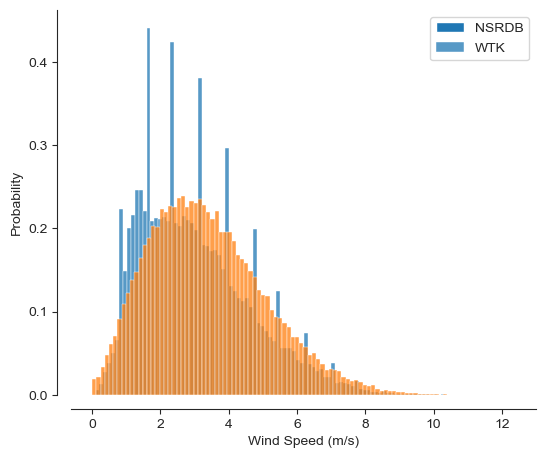

p-value = 0.00


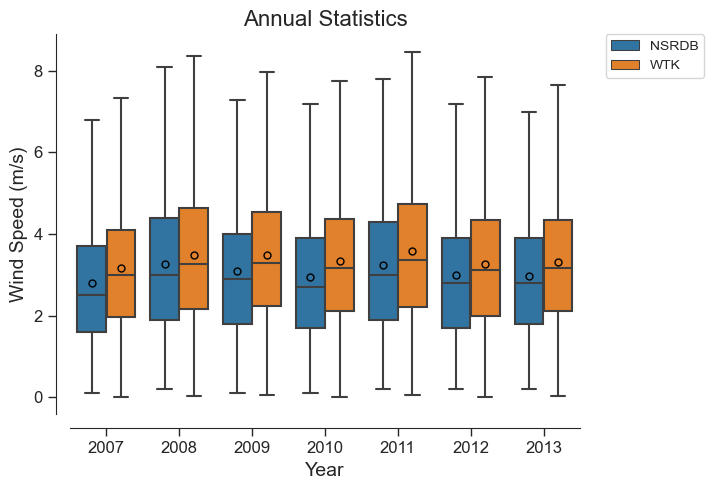

,2007,2008,2009,2010,2011,2012,2013
p-value,0.0,0.0,0.0,0.0,0.0,0.0,0.0


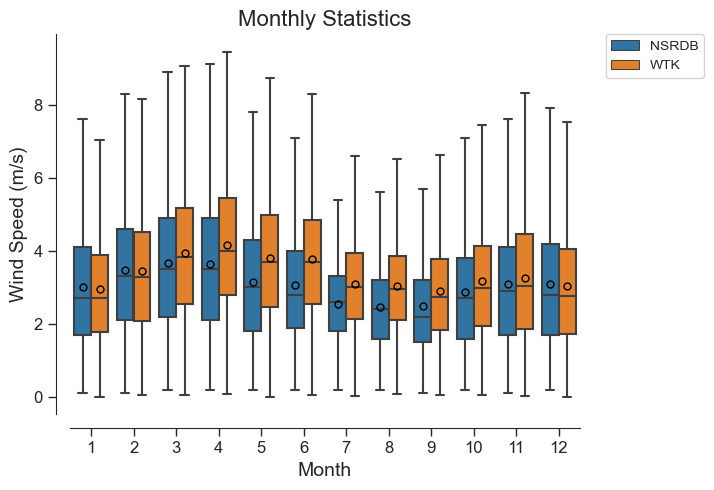

,1,2,3,4,5,6,7,8,9,10,11,12
p-value,0.0,0.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


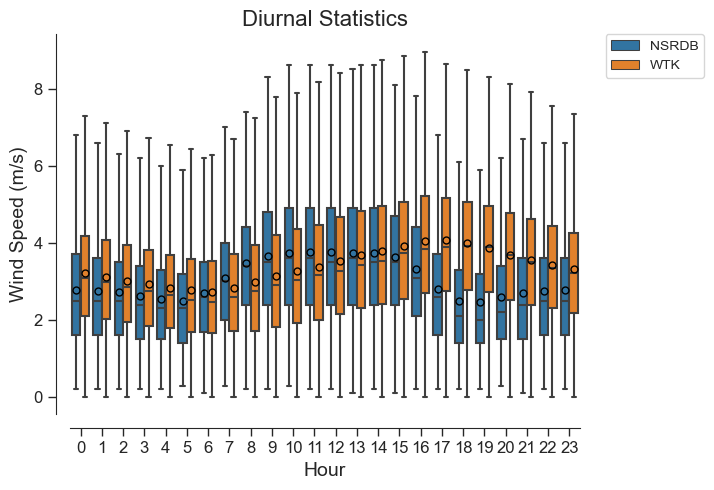

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
p-value,0.0,0.0,0.0,0.0,0.0,0.0,0.17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
variable = 'Wind Speed'
label = 'Wind Speed (m/s)'

nsrdb = comp_ds.loc[comp_ds['dataset'] == 'NSRDB', variable]
wtk = comp_ds.loc[comp_ds['dataset'] == 'WTK', variable]
fig, ax = plt.subplots(figsize=((6,5)), dpi=100)
sns.histplot(nsrdb, bins=100, ax=ax, stat='density', element='bars')
sns.histplot(wtk, bins=100, ax=ax, stat='density', element='bars')
sns.despine(offset=10, trim=False)
plt.ylabel('Probability')
plt.xlabel(label)
plt.legend(['NSRDB', 'WTK'])
plt.show()

p_val = wilcoxon(nsrdb, wtk)[1]
print('p-value = {:.2f}'.format(p_val))

fig = plt.figure(figsize=(6,5), dpi=100)
axis = fig.add_subplot(111)
axis.set_title('Annual Statistics', fontsize=16)
sns.boxplot(x='year', y=variable, hue='dataset', data=comp_ds,
            showfliers=False, ax=axis, showmeans=True, meanprops=meanprops)
sns.despine(offset=10, trim=False)
axis.set_xlabel('Year', fontsize=14)
axis.set_ylabel(label, fontsize=14)
axis.tick_params(axis='x', labelsize=12, width=1, length=6)
axis.tick_params(axis='y', labelsize=12, width=1, length=6)
fig.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
plt.close()

p_vals = pd.DataFrame()
groups = comp_ds.groupby('year')
for group, df in groups:
    nsrdb = df.loc[df['dataset'] == 'NSRDB', variable].values
    wtk = df.loc[df['dataset'] == 'WTK', variable].values
    p_vals.loc['p-value', group] = wilcoxon(nsrdb, wtk)[1]
    
display(p_vals.round(2))


fig = plt.figure(figsize=(6,5), dpi=100)
axis = fig.add_subplot(111)
axis.set_title('Monthly Statistics', fontsize=16)
sns.boxplot(x='month', y=variable, hue='dataset', data=comp_ds,
            showfliers=False, ax=axis, showmeans=True, meanprops=meanprops)
sns.despine(offset=10, trim=False)
axis.set_xlabel('Month', fontsize=14)
axis.set_ylabel(label, fontsize=14)
axis.tick_params(axis='x', labelsize=12, width=1, length=6)
axis.tick_params(axis='y', labelsize=12, width=1, length=6)
fig.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
plt.close()

p_vals = pd.DataFrame()
groups = comp_ds.groupby('month')
for group, df in groups:
    nsrdb = df.loc[df['dataset'] == 'NSRDB', variable].values
    wtk = df.loc[df['dataset'] == 'WTK', variable].values
    p_vals.loc['p-value', group] = wilcoxon(nsrdb, wtk)[1]
    
display(p_vals.round(2))


fig = plt.figure(figsize=(6,5), dpi=100)
axis = fig.add_subplot(111)
axis.set_title('Diurnal Statistics', fontsize=16)
sns.boxplot(x='hour', y=variable, hue='dataset', data=comp_ds,
           showfliers=False, ax=axis, showmeans=True, meanprops=meanprops)
sns.despine(offset=10, trim=False)
axis.set_xlabel('Hour', fontsize=14)
axis.set_ylabel(label, fontsize=14)
axis.tick_params(axis='x', labelsize=12, width=1, length=6)
axis.tick_params(axis='y', labelsize=12, width=1, length=6)
fig.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
plt.close()

p_vals = pd.DataFrame()
groups = comp_ds.groupby('hour')
for group, df in groups:
    nsrdb = df.loc[df['dataset'] == 'NSRDB', variable].values
    wtk = df.loc[df['dataset'] == 'WTK', variable].values
    p_vals.loc['p-value', group] = wilcoxon(nsrdb, wtk)[1]
    
with pd.option_context('display.max_rows', None, 'display.max_columns', 24):
    display(p_vals.round(2))

Take aways:
- The average Wind Speed is slightly higher in the WTK.
- But, the WTK and NSRDB indicate the same variability in the wind speed.
- The diurnal patters are poorly correlated between WTK and NSRDB.  
  The NSRDB indicated it is windiest during midday, while in the WTK  
  it is windiest in the evening.

### Conclusions for Meteorological Variables

The NSRDB's Temperature and Wind Speed is pulled from spatially coarse re-analysis data (MERRA).  
The WTK is also derived from coarse re-analysis data (ERA-interim),  
but is then resolved to a much high spatial resolution using the Weather Research and Forecasting Model (WRF).

As temperature is not expected to vary significantly spatially it is expected that the NSRDB and WTK temperatures  
should match up closely, which is indeed the case.  
- The slight differences are likley due to differences in the underlying re-analysis data.

Conversely wind speed does vary substantially over small spatial length scales and therefore it is unsurpising  
that the NSRDB and WTK measurements for a given site differ.
- Smoothing over the coarser grid would account for the lower average annual and monthly values in the NSRDB.
- Differences in the dirunal pattern is likely due to spatial discrepencies in the source data,  
  i.e. the WTK pixel is not coincident with the MERRA pixel used by the NSRDB.

# Statistical Significance
Two sided p-values

In [14]:
annual_stats = pd.DataFrame()
groups = solar_comp.groupby('year')
for group, df in groups:
    for var in ['GHI', 'DHI', 'DNI']:
        nsrdb = df.loc[df['dataset'] == 'NSRDB', var].values
        wtk = df.loc[df['dataset'] == 'WTK', var].values
        annual_stats.loc[group, var] = wilcoxon(nsrdb, wtk)[1]

annual_means = solar_comp.groupby(['dataset', 'year']).mean()
for var in ['GHI', 'DHI', 'DNI']:
    nsrdb = annual_means.loc['NSRDB'][var].values
    wtk = annual_means.loc['WTK'][var].values
    annual_stats.loc['Annual Means', var] = ttest_rel(nsrdb, wtk)[1]


groups = comp_ds.groupby('year')
for group, df in groups:
    for var in ['Temperature', 'Wind Speed']:
        nsrdb = df.loc[df['dataset'] == 'NSRDB', var].values
        wtk = df.loc[df['dataset'] == 'WTK', var].values
        annual_stats.loc[group, var] = wilcoxon(nsrdb, wtk)[1]
        
annual_means = comp_ds.groupby(['dataset', 'year']).mean()
for var in ['Temperature', 'Wind Speed']:
    nsrdb = annual_means.loc['NSRDB'][var].values
    wtk = annual_means.loc['WTK'][var].values
    annual_stats.loc['Annual Means', var] = ttest_rel(nsrdb, wtk)[1]
    
annual_stats.index.name = 'year'
annual_stats.round(2)

,GHI,DHI,DNI,Temperature,Wind Speed
year,,,,,
2007,0.0,0.00,0.00,0.00,0.0
2008,0.0,0.00,0.44,0.00,0.0
2009,0.0,0.00,0.03,0.00,0.0
2010,0.0,0.64,0.02,0.00,0.0
2011,0.0,0.00,0.02,0.00,0.0
2012,0.0,0.00,0.57,0.00,0.0
2013,0.0,0.00,0.87,0.00,0.0
Annual Means,0.0,0.00,0.00,0.01,0.0


In [15]:
monthly_stats = pd.DataFrame()
groups = solar_comp.groupby('month')
for group, df in groups:
    for var in ['GHI', 'DHI', 'DNI']:
        nsrdb = df.loc[df['dataset'] == 'NSRDB', var].values
        wtk = df.loc[df['dataset'] == 'WTK', var].values
        monthly_stats.loc[group, var] = wilcoxon(nsrdb, wtk)[1]

monthly_means = solar_comp.groupby(['dataset', 'month']).mean()
for var in ['GHI', 'DHI', 'DNI']:
    nsrdb = monthly_means.loc['NSRDB'][var].values
    wtk = monthly_means.loc['WTK'][var].values
    monthly_stats.loc['Monthly Means', var] = ttest_rel(nsrdb, wtk)[1]


groups = comp_ds.groupby('month')
for group, df in groups:
    for var in ['Temperature', 'Wind Speed']:
        nsrdb = df.loc[df['dataset'] == 'NSRDB', var].values
        wtk = df.loc[df['dataset'] == 'WTK', var].values
        monthly_stats.loc[group, var] = wilcoxon(nsrdb, wtk)[1]
        
monthly_means = comp_ds.groupby(['dataset', 'month']).mean()
for var in ['Temperature', 'Wind Speed']:
    nsrdb = monthly_means.loc['NSRDB'][var].values
    wtk = monthly_means.loc['WTK'][var].values
    monthly_stats.loc['Monthly Means', var] = ttest_rel(nsrdb, wtk)[1]
    
monthly_stats.index.name = 'month'
monthly_stats.round(2)

,GHI,DHI,DNI,Temperature,Wind Speed
month,,,,,
1,0.00,0.89,0.00,0.0,0.00
2,0.00,0.00,0.00,0.0,0.04
3,0.03,0.00,0.69,0.0,0.00
4,0.00,0.00,0.00,0.0,0.00
5,0.00,0.00,0.00,0.0,0.00
6,0.00,0.00,0.00,0.0,0.00
7,0.00,0.00,0.00,0.0,0.00
8,0.00,0.00,0.00,0.0,0.00
9,0.00,0.00,0.01,0.0,0.00


In [16]:
diurnal_stats = pd.DataFrame()
groups = solar_comp.groupby('hour')
for group, df in groups:
    for var in ['GHI', 'DHI', 'DNI']:
        nsrdb = df.loc[df['dataset'] == 'NSRDB', var].values
        wtk = df.loc[df['dataset'] == 'WTK', var].values
        diurnal_stats.loc[group, var] = wilcoxon(nsrdb, wtk)[1]

groups = comp_ds.groupby('hour')
for group, df in groups:
    for var in ['Temperature', 'Wind Speed']:
        nsrdb = df.loc[df['dataset'] == 'NSRDB', var].values
        wtk = df.loc[df['dataset'] == 'WTK', var].values
        diurnal_stats.loc[group, var] = wilcoxon(nsrdb, wtk)[1]
        
diurnal_stats = diurnal_stats.sort_index()
        
diurnal_means = solar_comp.groupby(['dataset', 'hour']).mean()
for var in ['GHI', 'DHI', 'DNI']:
    nsrdb = diurnal_means.loc['NSRDB'][var].values
    wtk = diurnal_means.loc['WTK'][var].values
    diurnal_stats.loc['Diurnal Means', var] = ttest_rel(nsrdb, wtk)[1]
        
diurnal_means = comp_ds.groupby(['dataset', 'hour']).mean()
for var in ['Temperature', 'Wind Speed']:
    nsrdb = diurnal_means.loc['NSRDB'][var].values
    wtk = diurnal_means.loc['WTK'][var].values
    diurnal_stats.loc['Diurnal Means', var] = ttest_rel(nsrdb, wtk)[1]
    
diurnal_stats.index.name = 'hour'
diurnal_stats.round(2)

,GHI,DHI,DNI,Temperature,Wind Speed
hour,,,,,
0,NaN,NaN,NaN,0.00,0.00
1,NaN,NaN,NaN,0.00,0.00
2,NaN,NaN,NaN,0.00,0.00
3,NaN,NaN,NaN,0.00,0.00
4,NaN,NaN,NaN,0.00,0.00
5,NaN,NaN,NaN,0.00,0.00
6,0.00,0.00,0.00,0.00,0.17
7,0.00,0.00,0.00,0.00,0.00
8,0.00,0.00,0.00,0.00,0.00
